### Chapter  4. 추정 (Deduce) 2

#### 4.1 유로 문제

- 동전을 250번 회전시켰을 때 앞면이 140회, 뒷면이 110회 나옴
- 동전이 한 쪽으로 기울어진 게 아니라면, 이렇게 나올 확률은 7% 미만이라 주장
- 이 데이터로 동전이 기울었다는 것을 증명할 수 있을까 ?


이 문제를 풀기 위해서는 2단계를 거쳐야 함.
1. 앞면이 나올 확률을 추정
2. 기울었다는 가설을 지지하는지 평가


앞면(H)가 나올 확률이 `x%` 라면, 뒷면(T)가 나올 확률은 `(100-x)%`

먼저 가장 간단한 `균등 사전 분포`로 계산
(모든 x에 대해서 같은 확률)

In [17]:
from python_code.thinkbayes import Suite
from matplotlib import pyplot as plt
import python_code.thinkbayes as bayes

In [2]:
class Euro(Suite):
    
    def Likelihood(self, data, hypo):
        x = hypo if data == 'H' else (100 - hypo)
        return x/100

In [5]:
euro = Euro(range(0,101))

for data in 'H' * 140 + 'T' * 110:
    euro.Update(data)

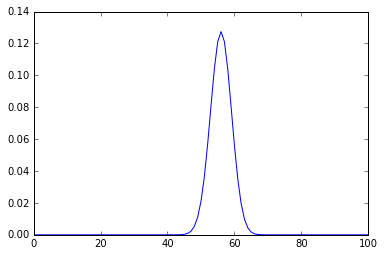

In [7]:
items = dict(euro.Items())
plt.plot(list(items.keys()), list(items.values()))
plt.show()

#### 4.2 사후 확률 요약

위에서 계산한 결과를 토대로 한번 살펴보자면

- 최대값

In [11]:
def MaxProb(pmf):
    _, val = max((prob, val) for val, prob in pmf.Items())
    return val

In [12]:
MaxProb(euro)

56

In [13]:
140/250

0.56

250번 중 앞면이 140 나왔으므로 56%라는 결과가 나온 것은 어찌보면 당연하다.

In [14]:
euro.Mean()

55.95238095238094

평균값은 55.95이며,

In [18]:
bayes.CredibleInterval(euro, 90)

(51, 61)

90% 신뢰구간은 51 ~ 61 사이다.
신뢰구간이 50%를 포함하고 있지 않으므로 평평하지 않다는 것을 확인할 수 있다.

In [19]:
euro.Prob(50)

0.02097652612954464

50%일 확률은 2%미만이다.

#### 4.3 사전 분포 범람

앞서 동전 던지기를 100번 했을 경우 앞면이 나온 횟수에 대한 확률을 모두 균등하게 두고 생각했지만, 실제로는 50%에 가까운 값에 더 높은 확률을 부여하는게 자연스러워 보인다.
그래서 삼각 사전 확률을 만들어 보자.

In [20]:
def GetTrianglePriorEuro():
    euro = Euro()
    for x in range(0, 51):
        euro.Set(x,x)
    for x in range(51, 101):
        euro.Set(x, 100-x)
    euro.Normalize()
    return euro

In [21]:
euroTri = GetTrianglePriorEuro()

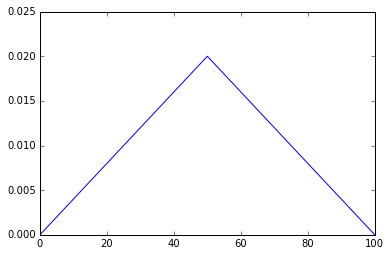

In [22]:
items = dict(euroTri.Items())
plt.plot(list(items.keys()), list(items.values()))
plt.show()

In [24]:
euroTri.Prob(50)

0.02

50%가 나올 확률이 기존(1%)에 비해 2%로 조금밖에 늘지 않았다.

In [25]:
for data in 'H' * 140 + 'T' * 110:
    euroTri.Update(data)

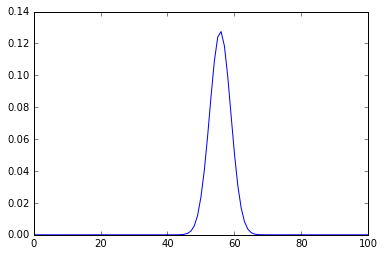

In [33]:
items = dict(euroTri.Items())
plt.plot(list(items.keys()), list(items.values()))
plt.show()

In [27]:
MaxProb(euroTri)

56

In [28]:
euroTri.Mean()

55.74349943859503

In [29]:
bayes.CredibleInterval(euroTri, 90)

(51, 61)

In [30]:
euroTri.Prob(50)

0.0238475372146936

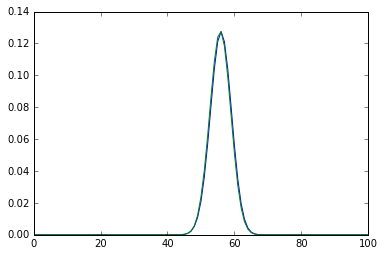

In [32]:
items = dict(euro.Items())
plt.plot(list(items.keys()), list(items.values()))

itemsTri = dict(euroTri.Items())
plt.plot(list(itemsTri.keys()), list(itemsTri.values()))

plt.show()

다른 사전 확률 모델을 사용했음에도 불구하고 사후 확률 분포는 거의 차이가 없다.
데이터가 충분하다면 서로 다른 사전 분포를 사용하더라도 동일한 사후 분포로 수렴하는 경향이 있다.
이것을 `사전 분포 범람`이라 한다.

#### 4.4 최적화

- 기존의 `Update`는 매번 `Normalize()`를 수행하게 되어 있는데 집합으로 전달하여 `Normalize()`를 한 번만하는 `UpdateSet`을 구현

In [1]:
def UpdateSet(self, dataset):
    for data in dataset:
        for hypo in self.Values():
            like = self.Likelihood(data, hypo)
            self.Mult(hypo, like)
    return self.Normailze()